## Import libraries and read data

In [1]:
# OS and Path
import os
from pathlib import Path

# Data and plot
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#ML
from sklearn.preprocessing import StandardScaler

# RDKit
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdFingerprintGenerator, rdMolDescriptors, AllChem, PandasTools, rdDepictor, rdFMCS
from rdkit.ML.Cluster import Butina
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image

In [2]:
HERE = Path(_dh[-1])
FOLDER = HERE.parent.parent/'data/fragments'

fda_ring_fragments = pd.read_csv(FOLDER/'unique/drug_fragments_no_duplicated.csv')
fda_ring_fragments

,parent_smiles,ring_fragment,chembl_id
0,Cc1cn[nH]c1,Cc1cn[nH]c1,CHEMBL1308
1,C1CNCCN1,C1CNCCN1,CHEMBL1412
2,Nc1ccncc1,Nc1ccncc1,CHEMBL284348
3,N[C@@H]1CONC1=O,N[C@@H]1CONC1=O,CHEMBL771
4,Nc1ccncc1N,Nc1ccncc1N,CHEMBL354077
...,...,...,...
3585,CCC(C)CCCCC(=O)NC(CCNCS(=O)(=O)O)C(=O)NC(C(=O)...,CC1NC(=O)C(N)CCNC(=O)C(C)NC(=O)C(C)NC(=O)C(C)N...,CHEMBL1201441
3586,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,C[C@@H]1O[C@@H](O)C[C@](C)(N)[C@@H]1O,CHEMBL507870
3587,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,C[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O,CHEMBL507870
3588,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,Cc1c(O)cc2c(c1O)-c1cc(ccc1O)[C@H]1NC(=O)[C@@H]...,CHEMBL507870


In [3]:
## rdkit.Chem.Mol object from SMILES and store it into a list
compounds = []
for _,ring_fragment, chembl_id in fda_ring_fragments[['ring_fragment', 'chembl_id']].itertuples():
    compounds.append((Chem.MolFromSmiles(ring_fragment), chembl_id))

print(f'Number of compounds successfully inserted into list: {len(compounds)}')
compounds[0:5]

Number of compounds successfully inserted into list: 3590


[(<rdkit.Chem.rdchem.Mol at 0x7fc3c63f71c0>, 'CHEMBL1308'),
 (<rdkit.Chem.rdchem.Mol at 0x7fc3c6438e80>, 'CHEMBL1412'),
 (<rdkit.Chem.rdchem.Mol at 0x7fc3c6438ca0>, 'CHEMBL284348'),
 (<rdkit.Chem.rdchem.Mol at 0x7fc3c6438c40>, 'CHEMBL771'),
 (<rdkit.Chem.rdchem.Mol at 0x7fc3c640e520>, 'CHEMBL354077')]

### Basic stats

In [4]:
from collections import Counter

# Count the number of rings
ring_counts = [rdMolDescriptors.CalcNumRings(compound) for compound, _ in compounds]
counter = Counter(ring_counts)

print(f"Number of fragments by ring size: \n{counter} \nTotal: {sum(counter.values())}")

Number of fragments by ring size: 
Counter({1: 2512, 2: 593, 4: 222, 3: 184, 5: 64, 7: 5, 6: 3, 8: 3, 10: 3, 11: 1}) 
Total: 3590


Plot the distribution of ring system size of FDA approved drugs:

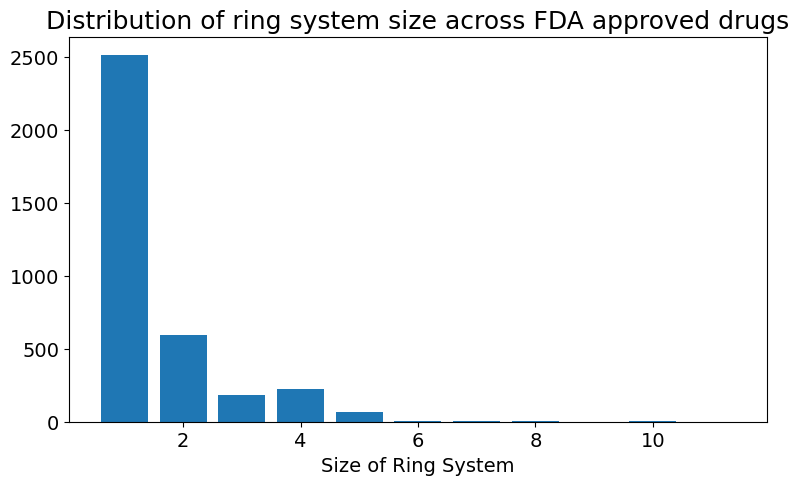

In [5]:
TITLE_FONT_SIZE = 18
AXIS_LABEL_FONT_SIZE = 14
fig, ax = plt.subplots(figsize=(9,5))

ax.bar(
    counter.keys(), 
    counter.values())
ax.set_title("Distribution of ring system size across FDA approved drugs", fontsize=TITLE_FONT_SIZE)
ax.set_xlabel("Size of Ring System", fontsize=AXIS_LABEL_FONT_SIZE)
ax.tick_params(axis='both', labelsize=AXIS_LABEL_FONT_SIZE)

### Number of unique fragments

In [6]:
## Number of unique ring fragments
# Convert ring_fragment to InChI (unique identifier by IUPAC)
ring_fragments_list = fda_ring_fragments['ring_fragment'].to_list()
rf_inchi = [Chem.MolToInchi(Chem.MolFromSmiles(rf)) for rf in  ring_fragments_list]

[16:44:13] WARNING: Omitted undefined stereo

[16:44:13] WARNING: Charges were rearranged

[16:44:13] WARNING: Omitted undefined stereo

[16:44:13] WARNING: Omitted undefined stereo

[16:44:13] WARNING: Accepted unusual valence(s): N+1(1)

[16:44:13] WARNING: Omitted undefined stereo

[16:44:13] WARNING: Omitted undefined stereo

[16:44:13] WARNING: Omitted undefined stereo

[16:44:13] WARNING: Omitted undefined stereo

[16:44:13] WARNING: Omitted undefined stereo

[16:44:13] WARNING: Proton(s) added/removed

[16:44:13] WARNING: Omitted undefined stereo

[16:44:13] WARNING: Accepted unusual valence(s): N+1(1)

[16:44:13] WARNING: Omitted undefined stereo

[16:44:13] WARNING: Accepted unusual valence(s): N+1(1)

[16:44:13] WARNING: Omitted undefined stereo

[16:44:13] WARNING: Omitted undefined stereo

[16:44:13] WARNING: Omitted undefined stereo

[16:44:13] WARNING: Omitted undefined stereo

[16:44:13] WARNING: Omitted undefined stereo

[16:44:13] WARNING: Charges were rearranged

[16:

In [7]:
# Count unique InChI
n_unique_rf = len(pd.Series(rf_inchi).unique())
print(f'The number of unique ring fragments of FDA approved small drugs is: {n_unique_rf}')

The number of unique ring fragments of FDA approved small drugs is: 1500


## Compute fingerprints, tanimoto similarity and distance matrix

### 1) Compute fingerprints

In [8]:
rdkit_fingerprint_generator = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_fingerprint_generator.GetFingerprint(mol) for mol, chembl_id in compounds]

print(f'Number of compounds converted: {len(fingerprints)} \
    Number of compounds present the dataset: {len(compounds)}\
    Fingerprint length per compound: {len(fingerprints[0])}')

Number of compounds converted: 3590     Number of compounds present the dataset: 3590    Fingerprint length per compound: 2048


### 2) Tanimoto similarity and distance matrix

Defining the function to compute the dissimilarity matrix. Because one is using a array of vectors to describe the features of a given structure, it is possible to use the `Tanimoto`, which is a distance metric, very often used to compare two array of bits for example. Below is the function to compute the distance or dissimilarity matrix of a list of vectors, in this case a `fingerprint` list.

In [9]:
def tanimoto_distance_matrix(fp_list:list) -> list:
    """
    Returns a distance matrix given a fingerprint list with any length of bits.
    (Depends on BulkTanimotoSimilarity from DataStructs module of rdkit)
    """
    dissimilarity_matrix = []

    for i in range(1, len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        dissimilarity_matrix.extend([1 - x for x in similarities])
    
    return dissimilarity_matrix

The number of elements in the distance matrix and the number of element sin a triangular matrix have to be the same:

In [13]:
n = len(fingerprints)
elem_triangular_matr =  ((n*(n-1))/2)
print(
    f'Elements in the triangular matrix: {elem_triangular_matr} ==\n',
    f'tanimoto_distance_matrix(fingerprints): {len(tanimoto_distance_matrix(fingerprints))}'
)

Elements in the triangular matrix: 6442255.0 ==
 tanimoto_distance_matrix(fingerprints): 6442255


### 3) Clustering process, select threshold

Create a helper function to cluster the fingerprints given a distance matrix.

In [14]:
def cluster_fingerprints(fingerprints, cutoff=0.2):
    """
    Clusterization given a list of fingerprints using the distance matrix.

    Parameters:
    fingerprints (list of computed fingerprints)
    """
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Calculate Tanimoto distance matrix
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

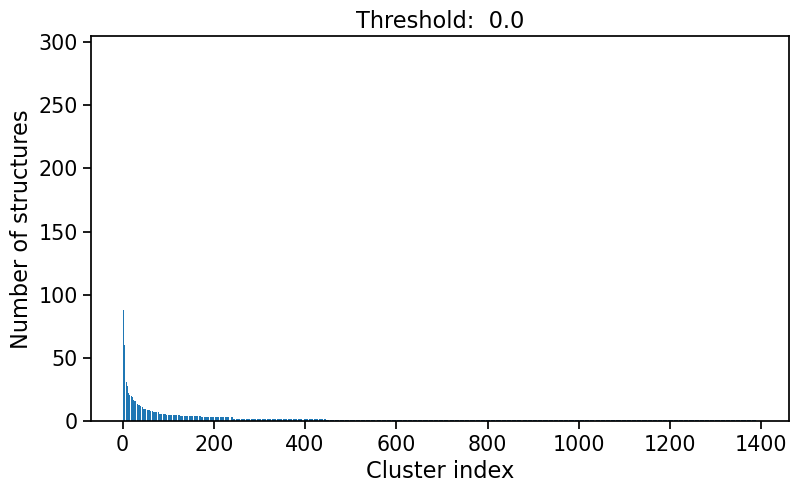

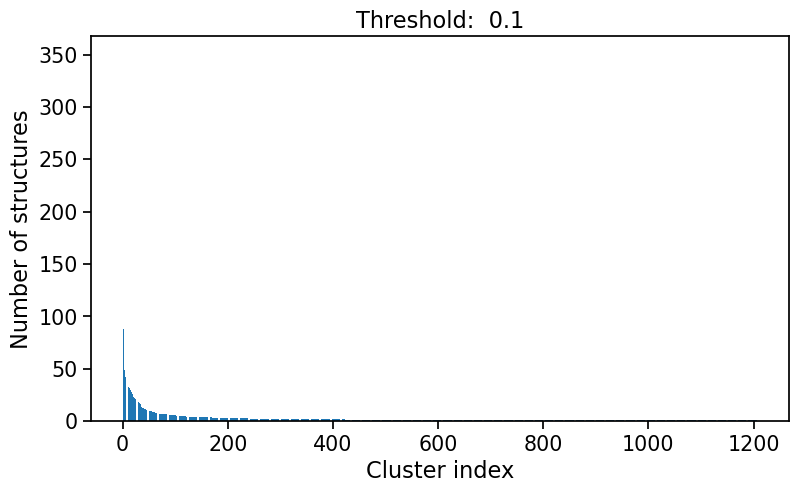

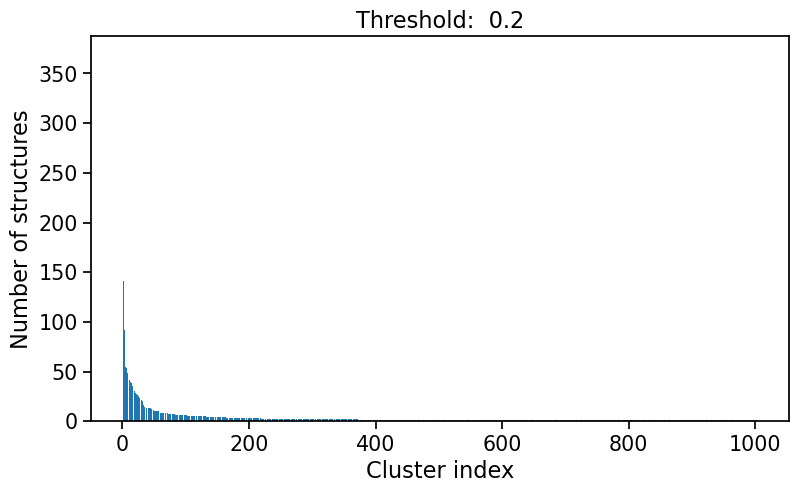

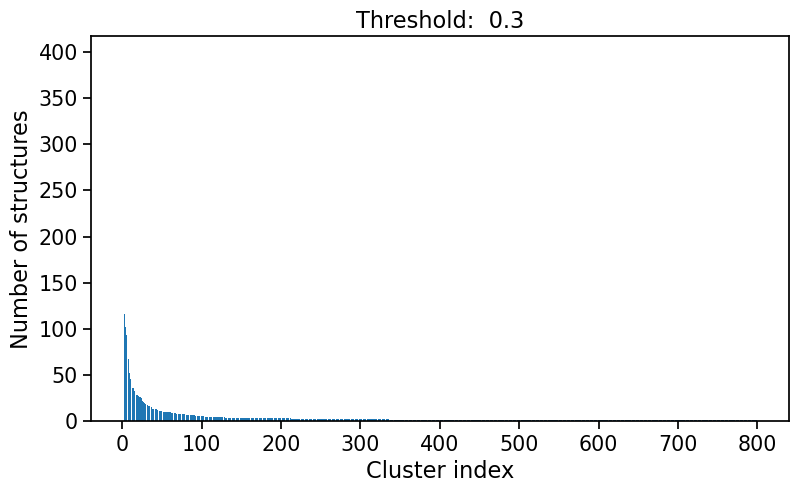

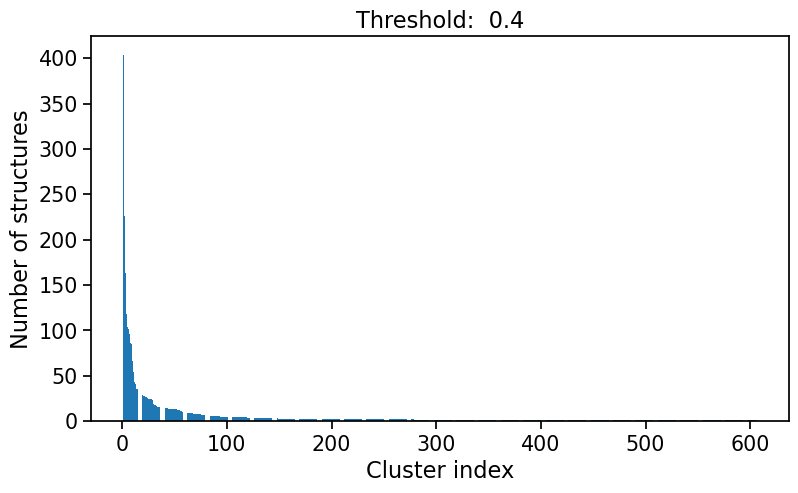

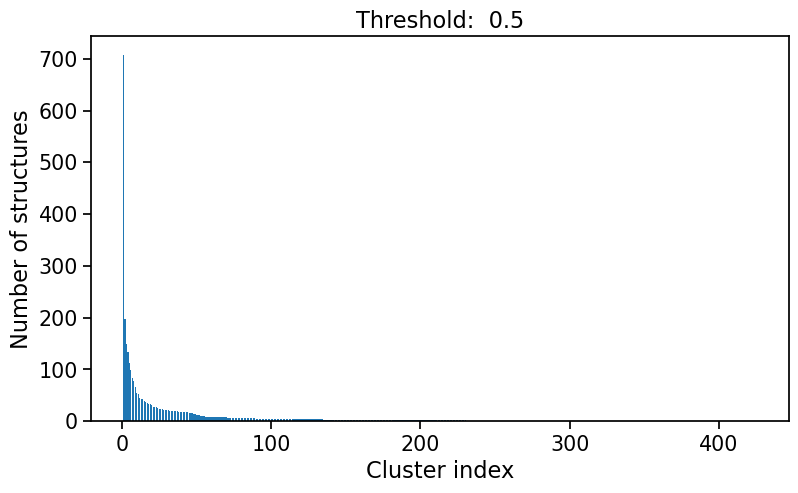

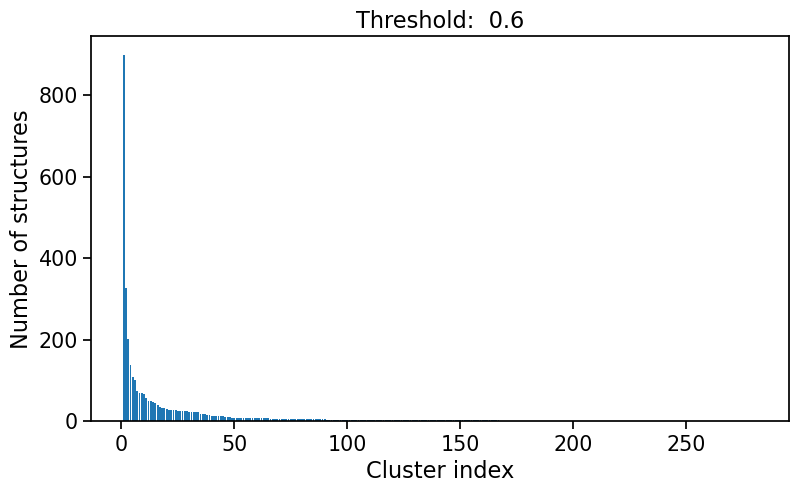

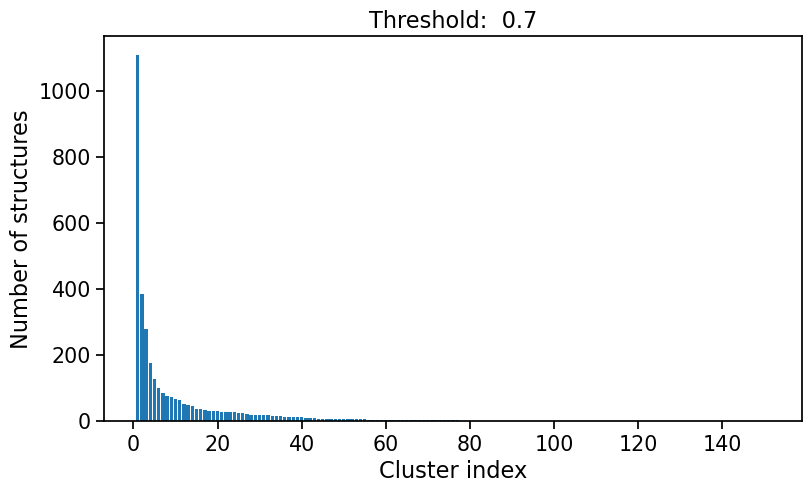

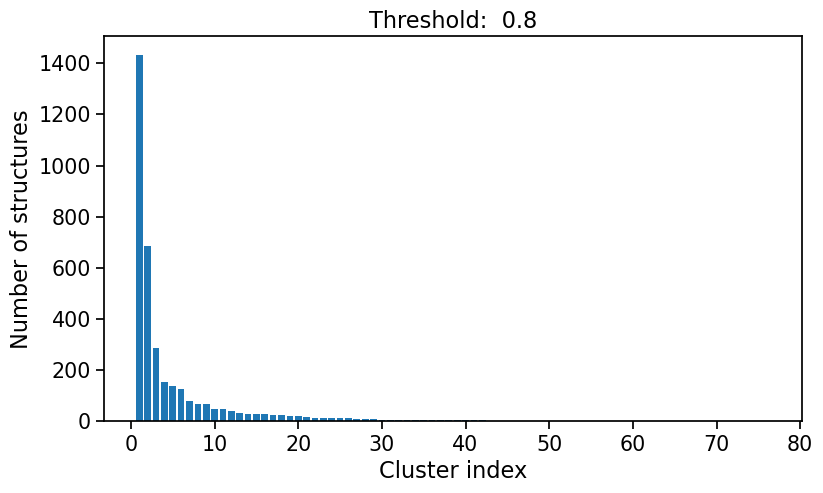

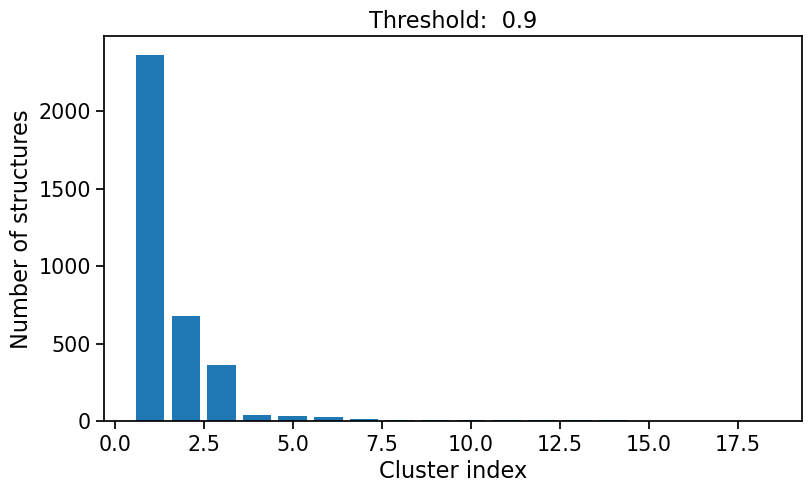

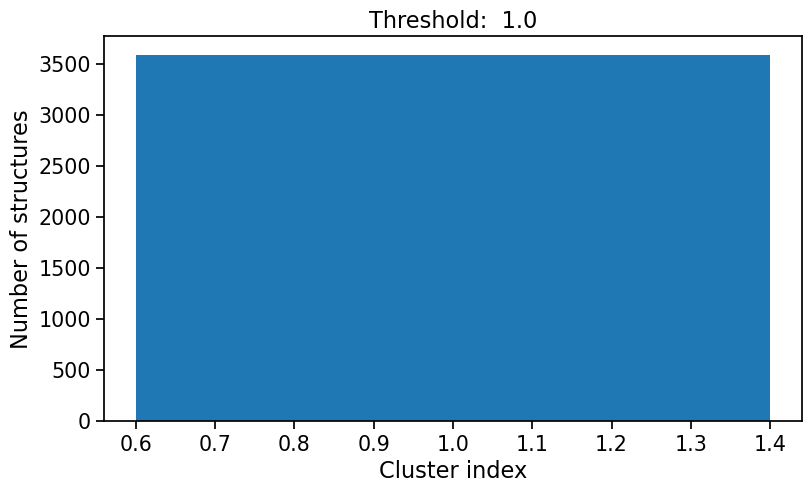

In [25]:
sns.set_context('notebook', font_scale=1.35) # augment font scale of everything
cutoffs = np.arange(0.0, 1.1, 0.1) # works the same as range(), [i, j[

for cutoff in cutoffs:
    clusters = cluster_fingerprints(fingerprints=fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.set_title(f'Threshold: {cutoff: 3.1f}')
    ax.set_xlabel('Cluster index')
    ax.set_ylabel('Number of structures')
    ax.bar(range(1, len(clusters) +1), [len(c) for c in clusters], lw=5)

Given that these entities consist of ring fragments rather than 'complete' structures, it becomes imperative to employ a rigorous threshold selection process, favoring a low value for dissimilarity and a high value for similarity. In terms of visual assessment, the option involving a threshold set at 0.1 appears to be the preferred choice.

(-5.0, 250.0)

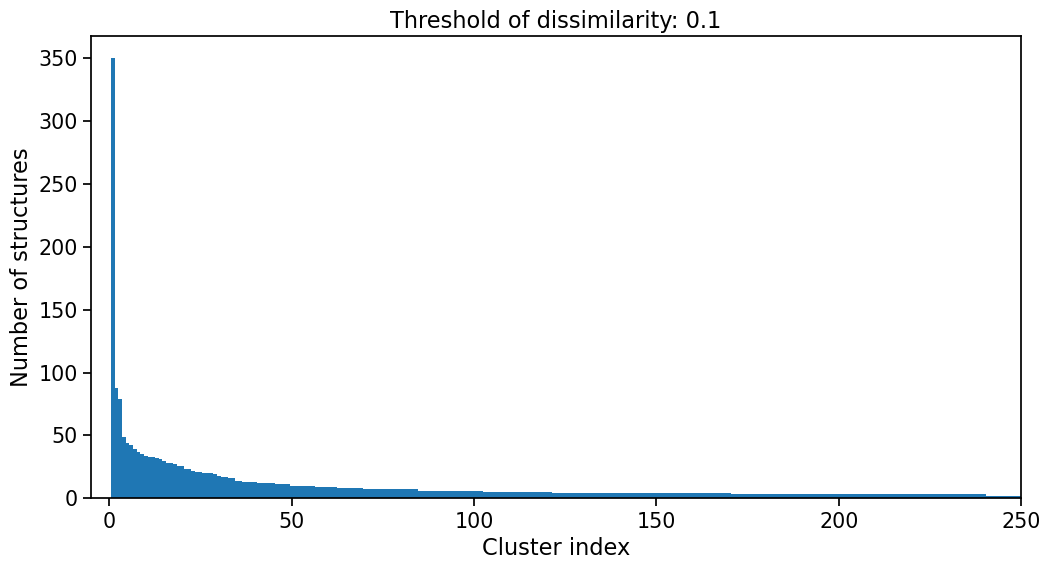

In [30]:
# Final selection of threshold
cutoff = 0.1
clusters = cluster_fingerprints(fingerprints=fingerprints, cutoff=cutoff)

# Plot
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlabel('Cluster index')
ax.set_ylabel('Number of structures')
ax.bar(range(1, len(clusters) +1), [len(c) for c in clusters], width=1)
ax.set_title(f'Threshold of dissimilarity: {cutoff}')
ax.set_xlim(-5, 250)

In [31]:
print(
    f"Number of clusters: {len(clusters)} from {len(compounds)} ring fragments",
    f"\n Number of RF in the first 10 clusters: {sum([len(clusters[x]) for x in range(0,10)])}",
    f"\n Number of RF in the first 20 clusters: {sum([len(clusters[x]) for x in range(0,20)])}",
    f"\n Number of RF in the first 50 clusters: {sum([len(clusters[x]) for x in range(0,50)])}",
    f"\n Number of RF in the first 100 clusters: {sum([len(clusters[x]) for x in range(0,100)])} "
)

Number of clusters: 1206 from 3590 ring fragments 
 Number of RF in the first 10 clusters: 797 
 Number of RF in the first 20 clusters: 1091 
 Number of RF in the first 50 clusters: 1558 
 Number of RF in the first 100 clusters: 1929 


## Visualization

Helper function to draw top n centroids and preferred draw options (specially fixedFontSize, which increases heteroatom label size)

In [50]:
# Drawing preferences
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.fixedFontSize = 18
IPythonConsole.drawOptions.legendFraction = 0.2
IPythonConsole.drawOptions.legendFontSize = 21

def draw_top_n_centroids(n, clusters, compounds, **kwargs):
    centroids = [cluster[0] for cluster in clusters[0:n]]
    mols = [compounds[c][0] for c in centroids]

    # Options
    molsPerRow = kwargs.get('molsPerRow', 5)
    subImgSize = kwargs.get('subImgSize', (200,150))
    maxMols = kwargs.get('maxMols', 50)
   
    return Draw.MolsToGridImage(
        mols,
        legends= [f'f: {len(c)}' for c in clusters[0:n]],
        molsPerRow=molsPerRow,
        subImgSize=subImgSize,
        maxMols=maxMols
    )

### Basic Draw Top RF Clusters Centroids

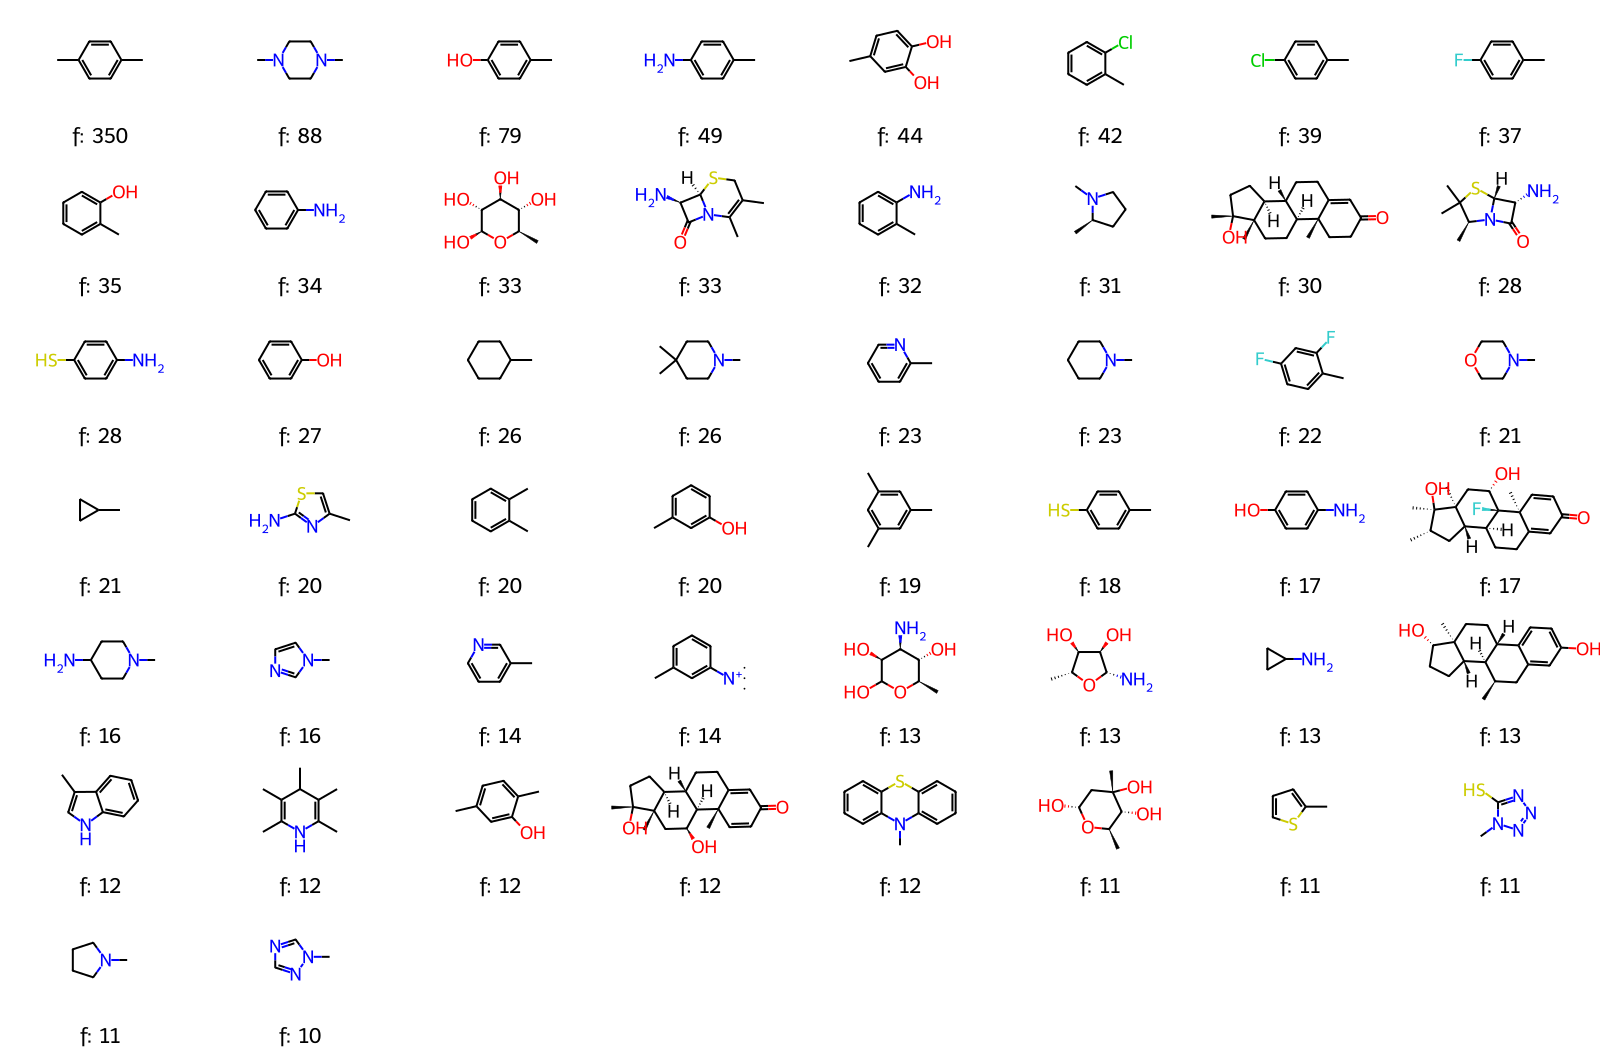

In [58]:
draw_top_n_centroids(100, clusters, compounds, molsPerRow=8, maxMols=50)

### Clusters Centroids and MCS highlighted

In [47]:
## For each cluster, retrieve a maximum common substructure mol

def get_clusters_mcs(clusters:list, compounds:list) -> list:
    """
    Recieves the cluster index list of a set of compounds (tuple) and computes the maximum common substructure inside each cluster.
    Returns a list of MCS mol objects of each cluster
    """

    mcs_clusters = []

    for cluster in clusters:
        if len(cluster) > 1:
            cluster_mols = [compounds[idx][0] for idx in cluster] # retrieves the mol object from compounds list
            res = rdFMCS.FindMCS(cluster_mols) # compute the MCS
            mcs_mol = Chem.MolFromSmarts(res.smartsString) # get the mol object of the computed MCS
            mcs_clusters.append(mcs_mol)

    return mcs_clusters

In [63]:
n = 100
clusters_mcs_mols = get_clusters_mcs(clusters=clusters[0:n], compounds=compounds)

# Getting mols of the first n clusters centroids
top_n_centroids = [cluster[0] for cluster in clusters[0:n]]
top_n_mol_centroids = [compounds[i][0] for i in top_n_centroids]

# Legend for the plot (size of each cluster)
legends_top_n_centroids = [f"n = {len(c)}" for c in clusters[0:n]]

# Getting the matches
matches = [list(centroid.GetSubstructMatch(mcs)) for mcs, centroid in zip(clusters_mcs_mols, top_n_mol_centroids)]

/home/gustavos/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


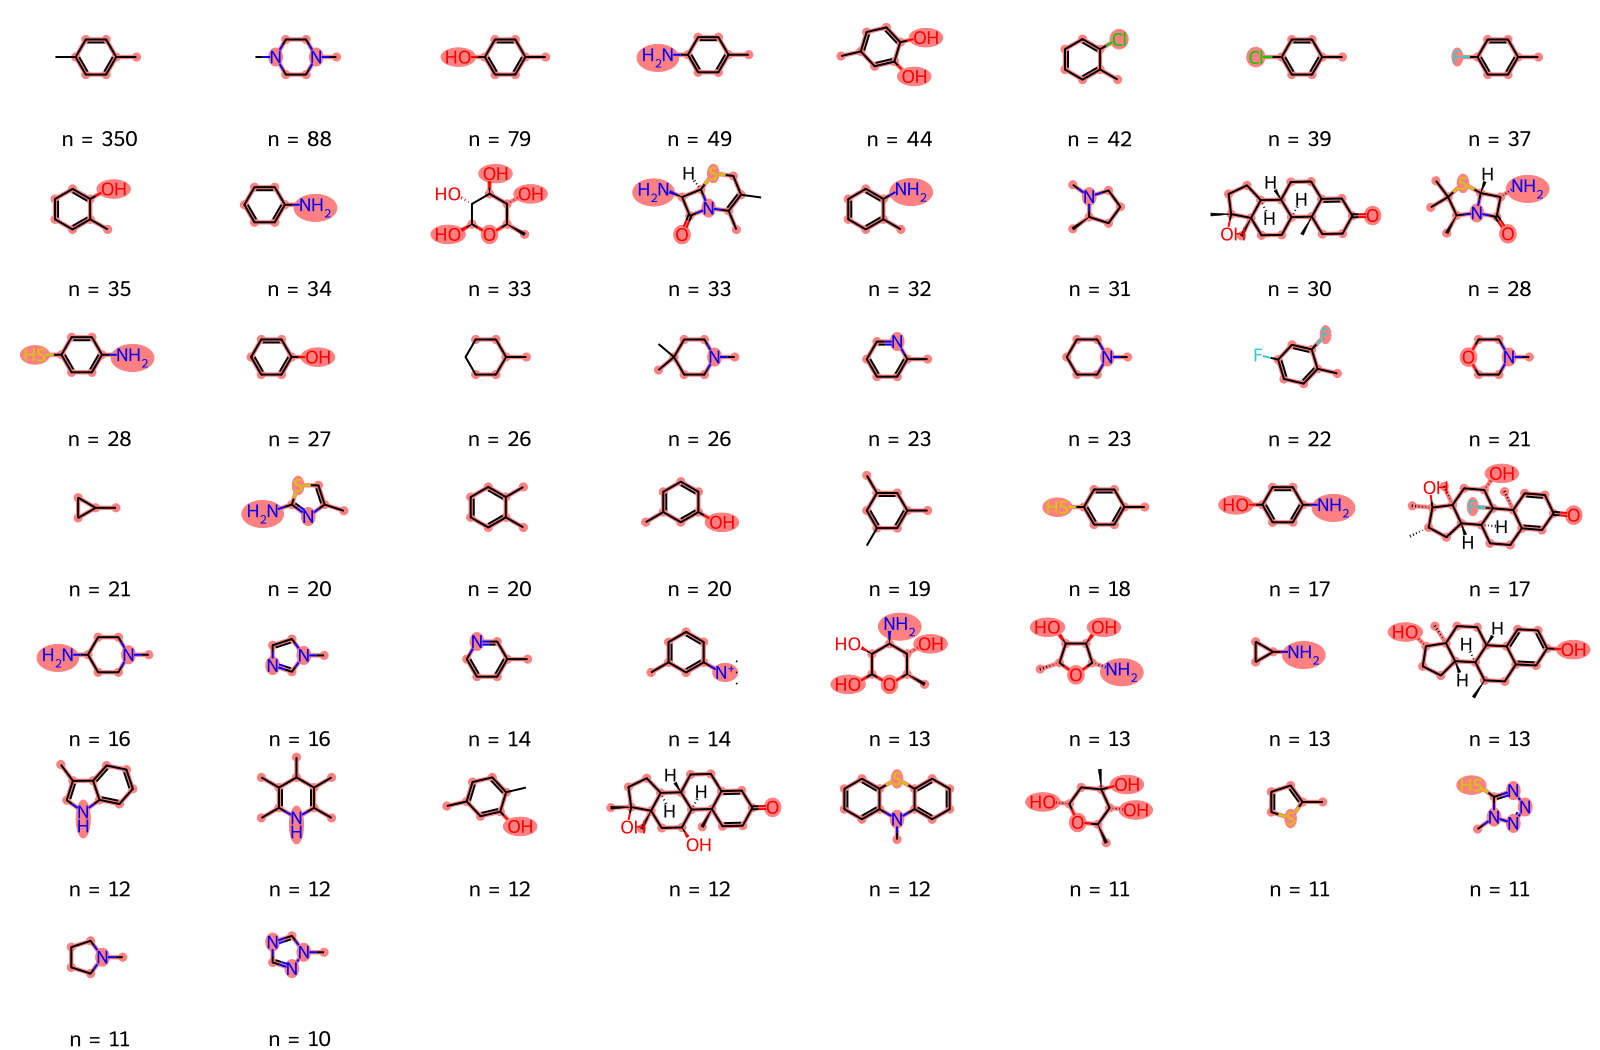

In [66]:
Draw.MolsToGridImage(
    top_n_mol_centroids, 
    highlightAtomLists=matches,
    legends=legends_top_n_centroids,
    subImgSize=(200,150), 
    molsPerRow=8)

### Separate by ring size

In [67]:
one_ring = []
matches_one_ring = []

two_rings = []
matches_two_rings = []

three_rings = []
matches_three_rings = []

four_or_more_rings = []
matches_four_or_more_rings = []

# Rings
cluster_mcs_and_centroids = zip(clusters_mcs_mols, top_n_mol_centroids, legends_top_n_centroids)
for mcs, centroid, legend in cluster_mcs_and_centroids:
    
    number_of_rings = rdMolDescriptors.CalcNumRings(centroid)
    
    if number_of_rings == 1:
        one_ring.append((centroid, legend))
        matches_one_ring.append(list(centroid.GetSubstructMatch(mcs)))

    elif number_of_rings == 2:
        two_rings.append((centroid, legend))
        matches_two_rings.append(list(centroid.GetSubstructMatch(mcs)))
    
    elif number_of_rings == 3:
        three_rings.append((centroid, legend))
        matches_three_rings.append(list(centroid.GetSubstructMatch(mcs)))
    
    else:
        four_or_more_rings.append((centroid, legend))
        matches_four_or_more_rings.append(list(centroid.GetSubstructMatch(mcs)))

In [68]:
def draw_clusters_by_ring_number(n_rings, matches, **kwargs):
    mols = [t[0] for t in n_rings]
    legend = [t[1] for t in n_rings]

    return Draw.MolsToGridImage(
        mols,
        legends= legend,
        highlightAtomLists=matches,
        subImgSize=kwargs['subImgSize'],
        molsPerRow=kwargs['molsPerRow'],
        maxMols = kwargs['maxMols']
    )

#### 1 Ring)

78


/home/gustavos/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


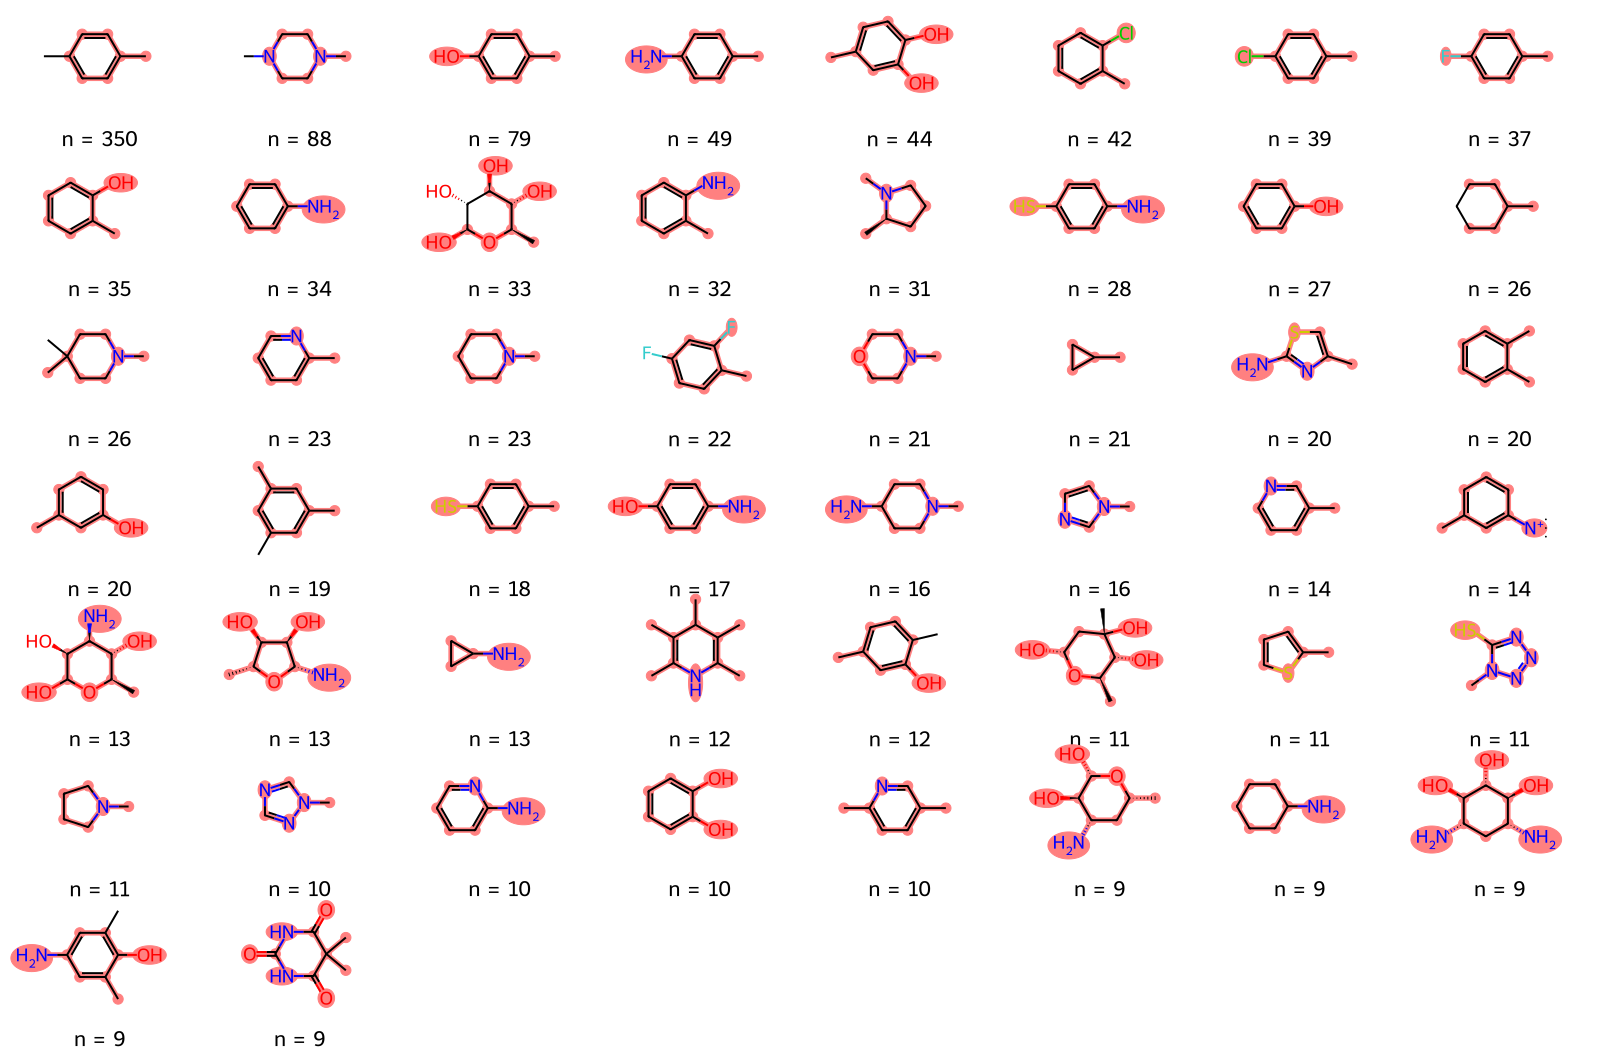

In [87]:
print(len(one_ring))
draw_clusters_by_ring_number(one_ring, matches=matches_one_ring, molsPerRow=8, subImgSize=(200,150), maxMols=50)

#### 2 Rings)

10


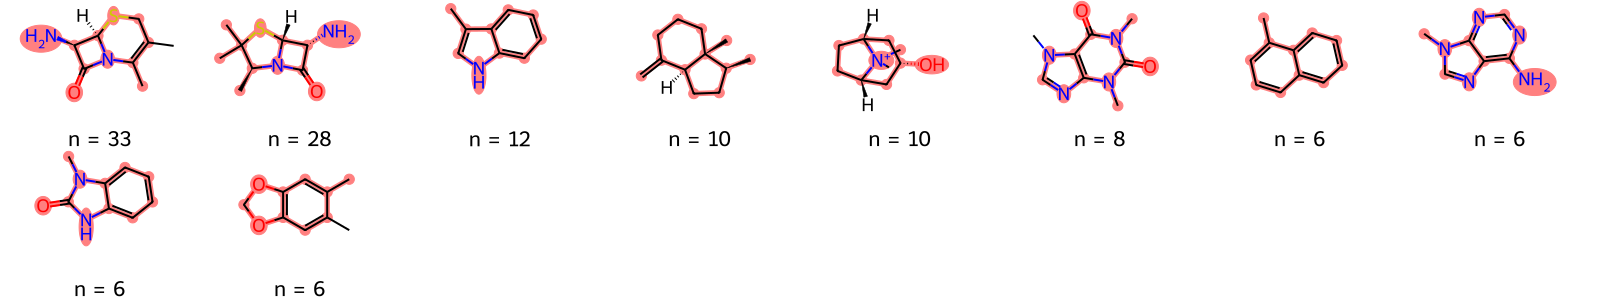

In [90]:
print(len(two_rings))
draw_clusters_by_ring_number(two_rings, matches=matches_two_rings,  molsPerRow=8, subImgSize=(200,150), maxMols=50)

#### 3 rings)

2


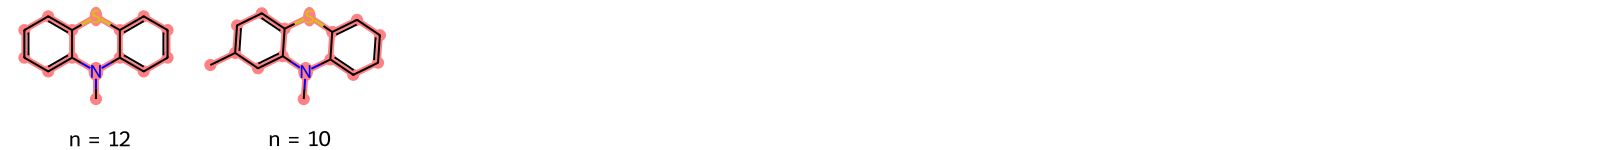

In [91]:
print(len(three_rings))
draw_clusters_by_ring_number(three_rings, matches=matches_three_rings,  molsPerRow=8, subImgSize=(200,150), maxMols=50)

#### 4 rings)

10


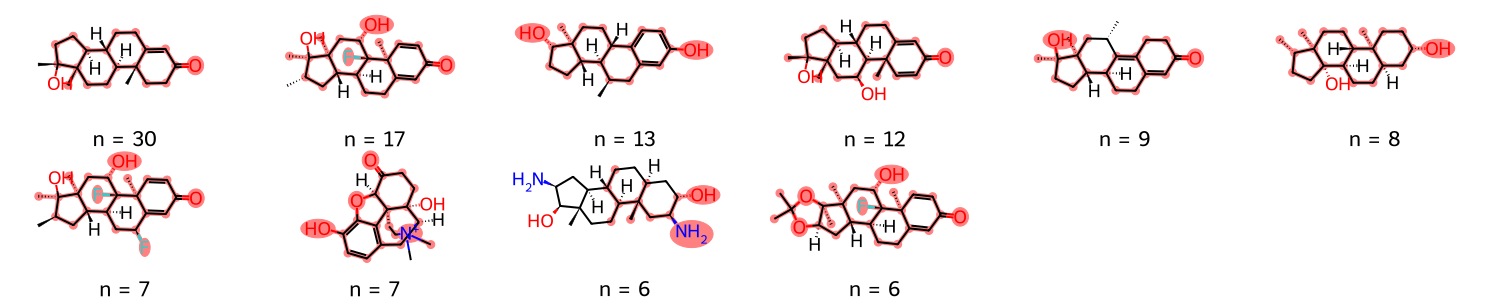

In [92]:
print(len(four_or_more_rings))
draw_clusters_by_ring_number(four_or_more_rings, matches=matches_four_or_more_rings, molsPerRow=6, subImgSize=(250,150), maxMols=50)